In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix,cohen_kappa_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [3]:
Y = np.load('y_data_wpd.npy')
X_flatten = np.load('x_data_wpd .npy')

df = pd.DataFrame(X_flatten)
df['target'] = Y

df.shape

(830, 84)

### Labels number with meanings
### 1)  1: Artifacts Sounds
### 2)  2: Normal Sounds
### 3)  3: Extrahals Sounds
### 4)  4: Murmur sounds
### 5) -1: Unlabelled

In [4]:
train = df[df['target']!=-1]  # training dataset
test = df[df['target']==-1]   # unlabelled/test dataset

In [5]:
def model(steps,params,X,y):
    
    pipeline = Pipeline(steps)
    gv_model = GridSearchCV(pipeline,param_grid=params,cv=10)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42, shuffle = True)
    gv_model.fit(X_train,y_train)
    
    y_pred_train = gv_model.predict(X_train)
    y_pred_test = gv_model.predict(X_test)
    
    
    cross_val = cross_val_score(gv_model,X,y,cv=5)
    
    params = {
        'y_pred_train':y_pred_train,
        'y_pred_test':y_pred_test,
        'y_train':y_train,
        'y_test':y_test,
        'model':gv_model,
        'cross_val':cross_val
    }
    
    return params

In [6]:
def print_performance_metrics(y_test,pred_test):
  
    print('Accuracy:', np.round(metrics.accuracy_score(y_test,pred_test),4))
    print('Precision:', np.round(metrics.precision_score(y_test, 
                               pred_test,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, pred_test,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred_test,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test,pred_test),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test,pred_test),4)) 
    #print('ROC AUC:', (metrics.roc_auc_score(y_test,pred_test,multi_class = 'ovo')))
    print('\t\tClassification Report:\n', metrics.classification_report(y_test, pred_test))
    mat = confusion_matrix(y_test,pred_test)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [7]:
# SVC
steps = [('scaler',MinMaxScaler()),('svc',SVC(kernel='poly'))]
params = {'svc__C':[0.5,0.8,1],'svc__degree':[3,4,5]}

par_svc = model(steps,params,train.drop('target',axis=1),train['target'])

In [8]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_svc['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_svc['y_train'],par_svc['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6781167108753315
Score of Training Set : 0.7782258064516129


Accuracy: 0.625
Precision: 0.6018
Recall: 0.625
F1 Score: 0.5078
Cohen Kappa Score: 0.2637
Matthews Corrcoef: 0.3859
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86         7
         1.0       0.59      1.00      0.75        47
         2.0       0.00      0.00      0.00         9
         3.0       1.00      0.11      0.19        19
         4.0       0.00      0.00      0.00         6

    accuracy                           0.62        88
   macro avg       0.49      0.39      0.36        88
weighted avg       0.60      0.62      0.51        88



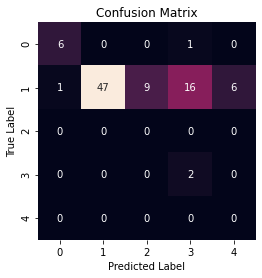

In [9]:
print_performance_metrics(par_svc['y_test'],par_svc['y_pred_test'])

In [10]:
# Decision Tree
steps = [('scaler',StandardScaler()),('tree',DecisionTreeClassifier())]
params = {
         'tree__criterion':['gini','entropy'],
        'tree__max_depth':[3,4,5,6],
        'tree__min_samples_split':[2,3,4,5],
        'tree__max_features':['sqrt','log2']
}
par_ds = model(steps,params,train.drop('target',axis=1),train['target'])

In [11]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_ds['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_ds['y_train'],par_ds['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6436339522546419
Score of Training Set : 0.8084677419354839


Accuracy: 0.5909
Precision: 0.5122
Recall: 0.5909
F1 Score: 0.5137
Cohen Kappa Score: 0.2507
Matthews Corrcoef: 0.2876
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.86      0.80         7
         1.0       0.60      0.89      0.72        47
         2.0       0.50      0.11      0.18         9
         3.0       0.38      0.16      0.22        19
         4.0       0.00      0.00      0.00         6

    accuracy                           0.59        88
   macro avg       0.45      0.40      0.38        88
weighted avg       0.51      0.59      0.51        88



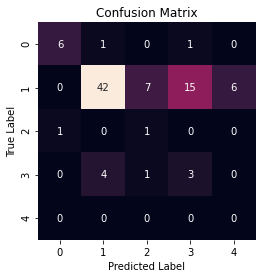

In [12]:
print_performance_metrics(par_ds['y_test'],par_ds['y_pred_test'])

In [13]:
# RandomForest
steps = [('rf',RandomForestClassifier())]
params = {'rf__n_estimators':[150,200,250],
          'rf__max_depth':[4,5],
          'rf__min_samples_split':[2],
          'rf__min_samples_leaf':[3],
          'rf__n_jobs':[-1]
         }
par_rf = model(steps,params,train.drop('target',axis=1),train['target'])

In [14]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_rf['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_rf['y_train'],par_rf['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.7106100795755967
Score of Training Set : 0.8004032258064516


In [16]:
# Gradient Boosting
steps = [('gbt',GradientBoostingClassifier())]
params = {
    'gbt__n_estimators':[50],
    'gbt__learning_rate':[0.1,0.5],
    'gbt__max_depth':[2,3],
    'gbt__min_samples_split':[3],
    'gbt__max_features':['log2','sqrt']
}
par_gbt = model(steps,params,train.drop('target',axis=1),train['target'])

In [17]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_gbt['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_gbt['y_train'],par_gbt['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.7019893899204244
Score of Training Set : 0.9939516129032258


Accuracy: 0.7386
Precision: 0.7597
Recall: 0.7386
F1 Score: 0.7249
Cohen Kappa Score: 0.5629
Matthews Corrcoef: 0.5812
		Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92         7
         1.0       0.73      0.91      0.81        47
         2.0       0.50      0.56      0.53         9
         3.0       0.90      0.47      0.62        19
         4.0       0.67      0.33      0.44         6

    accuracy                           0.74        88
   macro avg       0.76      0.63      0.67        88
weighted avg       0.76      0.74      0.72        88



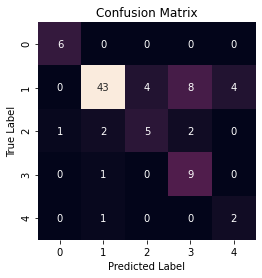

In [18]:
print_performance_metrics(par_gbt['y_test'],par_gbt['y_pred_test'])

In [19]:
# XGBoosting
steps = [('xgb',XGBClassifier())]
params = {
    'xgb__n_estimators':[120],
    'xgb__learning_rate':[0.08],
    'xgb__max_depth':[2,3],
    'xgb__gamma':[1]
}
par_xgb = model(steps,params,train.drop('target',axis=1),train['target'])

[02:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[02:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[02:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[02:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[02:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [20]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_xgb['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_xgb['y_train'],par_xgb['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6865605658709107
Score of Training Set : 0.9637096774193549


Accuracy: 0.6477
Precision: 0.6341
Recall: 0.6477
F1 Score: 0.5856
Cohen Kappa Score: 0.3599
Matthews Corrcoef: 0.4007
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86         7
         1.0       0.63      0.91      0.75        47
         2.0       1.00      0.11      0.20         9
         3.0       0.58      0.37      0.45        19
         4.0       0.00      0.00      0.00         6

    accuracy                           0.65        88
   macro avg       0.61      0.45      0.45        88
weighted avg       0.63      0.65      0.59        88



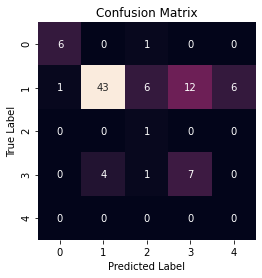

In [21]:
print_performance_metrics(par_xgb['y_test'],par_xgb['y_pred_test'])

In [22]:
# AdaBoost
clf_r = RandomForestClassifier(n_estimators=200,max_depth=5,min_samples_split=2,min_samples_leaf=3,n_jobs=-1)
steps = [('scaler',MinMaxScaler()),('adb',AdaBoostClassifier(clf_r))]
params = {
     'adb__n_estimators':[5,6],
    'adb__learning_rate':[0.01],
    'adb__algorithm':['SAMME.R']
}
par_adb = model(steps,params,train.drop('target',axis=1),train['target'])

In [23]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_adb['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_adb['y_train'],par_adb['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.7037430002947244
Score of Training Set : 0.7923387096774194


Accuracy: 0.625
Precision: 0.5326
Recall: 0.625
F1 Score: 0.5313
Cohen Kappa Score: 0.284
Matthews Corrcoef: 0.3609
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86         7
         1.0       0.60      0.96      0.74        47
         2.0       0.00      0.00      0.00         9
         3.0       0.67      0.21      0.32        19
         4.0       0.00      0.00      0.00         6

    accuracy                           0.62        88
   macro avg       0.42      0.41      0.38        88
weighted avg       0.53      0.62      0.53        88



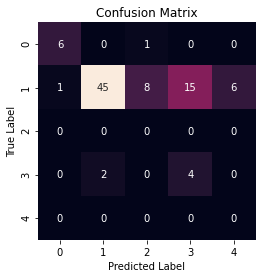

In [24]:
print_performance_metrics(par_adb['y_test'],par_adb['y_pred_test'])